# Task 1.2 extra: Text Mining

In [1151]:
import numpy as np
import pandas as pd
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
import webcolors
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

## Loading the new dataset

In [1152]:
df = pd.read_csv('../dataset/new_customer_supermarket.csv', sep='\t', index_col=0)
df

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta,TotSale
0,539993,2011-04-01 10:00:00,1.95,13313.0,22386,JUMBO BAG PINK POLKADOT,10,19.5
1,539993,2011-04-01 10:00:00,0.42,13313.0,21499,BLUE POLKADOT WRAP,25,10.5
2,539993,2011-04-01 10:00:00,0.42,13313.0,21498,RED RETROSPOT WRAP,25,10.5
3,539993,2011-04-01 10:00:00,2.10,13313.0,22379,RECYCLING BAG RETROSPOT,5,10.5
4,539993,2011-04-01 10:00:00,1.25,13313.0,20718,RED RETROSPOT SHOPPER BAG,10,12.5
...,...,...,...,...,...,...,...,...
280142,581585,2011-09-12 12:31:00,0.95,15804.0,23145,ZINC TLIGHT HOLDER STAR LARGE,12,11.4
280143,581585,2011-09-12 12:31:00,1.95,15804.0,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,23.4
280144,581586,2011-09-12 12:49:00,2.95,13113.0,22061,LARGE CAKE STAND HANGING STRAWBERY,8,23.6
280145,581586,2011-09-12 12:49:00,1.25,13113.0,23275,SET OF HANGING OWLS OLLIE BEAK,24,30.0


In [1153]:
df.dtypes

BasketID        int64
BasketDate     object
Sale          float64
CustomerID    float64
ProdID         object
ProdDescr      object
Qta             int64
TotSale       float64
dtype: object

In [1154]:
df = df.astype({'BasketDate': 'datetime64',
                'BasketID': 'object',
                'CustomerID': 'object'})

In [1155]:
products = pd.DataFrame(df['ProdDescr'].unique()).rename(columns={0: 'ProdDescr'})
products

,ProdDescr
0,JUMBO BAG PINK POLKADOT
1,BLUE POLKADOT WRAP
2,RED RETROSPOT WRAP
3,RECYCLING BAG RETROSPOT
4,RED RETROSPOT SHOPPER BAG
...,...
3382,CLASSICAL ROSE TABLE LAMP
3383,PINK CRYSTAL SKULL PHONE CHARM
3384,PINK JEWELLED MIRROR TRINKET TRAY
3385,CREAM HANGING HEART TLIGHT HOLDER


In [1156]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
colors |= webcolors.CSS3_NAMES_TO_HEX.keys()

def lemmatize_descr(descr):
    # print(pos_tag(word_tokenize(descr.lower())))
    tokenized_descr = [token for token, pos in pos_tag(word_tokenize(descr.lower()))
                       if not token in stop_words and 
                       not any(c in token for c in colors) and 
                       len(token) >= 3 and 
                       (pos == 'NN' or pos == 'NNS')]
    return ' '.join(lemmatizer.lemmatize(token) for token in tokenized_descr)

In [1157]:
products['ProdDescr'] = products['ProdDescr'].apply(lemmatize_descr)
products

,ProdDescr
0,bag polkadot
1,polkadot wrap
2,retrospot wrap
3,bag retrospot
4,retrospot shopper bag
...,...
3382,lamp
3383,skull phone charm
3384,mirror trinket tray
3385,cream heart tlight holder


In [1158]:
products.drop_duplicates(ignore_index=True, inplace=True)
products

,ProdDescr
0,bag polkadot
1,polkadot wrap
2,retrospot wrap
3,bag retrospot
4,retrospot shopper bag
...,...
2742,sweetheart wire fruit bowl
2743,zinc wire kitchen organiser
2744,skull phone charm
2745,cream heart tlight holder


In [1159]:
keywords_counter = Counter(word for descr in products['ProdDescr'] for word in descr.split())
print("Nb of keywords in '{}': {}".format('ProdDescr', len(keywords_counter)))

Nb of keywords in 'ProdDescr': 1290


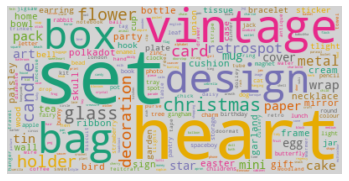

In [1160]:
word_cloud = WordCloud(max_words=300, background_color='lightgrey', colormap='Dark2')
word_cloud.generate_from_frequencies(keywords_counter)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()
# word_cloud.to_file('path')

In [1161]:
model = Word2Vec([[word for word in descr.split()] 
                  for descr in products['ProdDescr']], min_count=1)
model.init_sims()
sims = np.dot(model.wv.vectors_norm, model.wv.vectors_norm.T)
sims.shape

(1290, 1290)

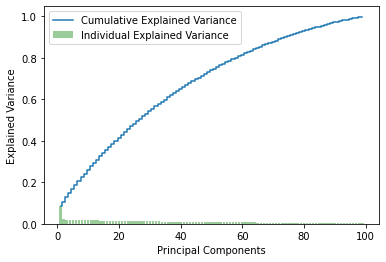

In [1162]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(sims)

plt.step(range(1, 100), pca.explained_variance_ratio_.cumsum()[:99], 
         where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, 100), pca.explained_variance_ratio_[:99], 
        alpha=0.4, color='g', label='Individual Explained Variance')

plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc='upper left');

In [1163]:
pca = PCA(n_components=60)
pca_sims = pca.fit_transform(sims)

In [1164]:
elbow = []
silhouette = []
for k in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    clusters = kmeans.fit_predict(pca_sims)
    elbow.append(kmeans.inertia_)
    silhouette.append(silhouette_score(pca_sims, clusters))

In [1165]:
print('The best silhouette score is:', max(silhouette))

The best silhouette score is: 0.06279756


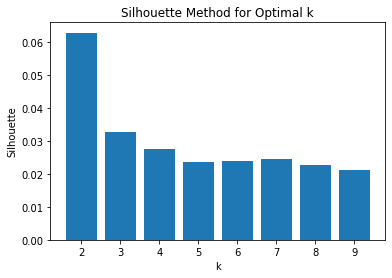

In [1166]:
plt.bar(range(2, 10), silhouette)
plt.title('Silhouette Method for Optimal k')
plt.ylabel('Silhouette')
plt.xlabel('k');

In [1167]:
kmeans = KMeans(init='k-means++', n_clusters=2)
cluster_words = kmeans.fit_predict(pca_sims)

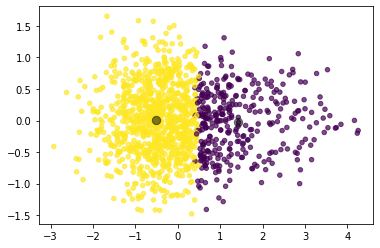

In [1168]:
# create a scatter plot
plt.scatter(pca_sims[:, 0], pca_sims[:, 1], c=cluster_words, s=20, alpha=0.7)
# select cluster centers
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [1169]:
pd.DataFrame(pd.Series(cluster_words).value_counts(), columns=['WordsNb']).T

,1,0
WordsNb,948,342


### Elbow method

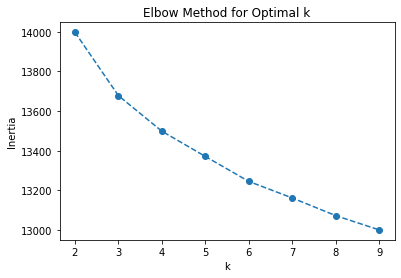

In [1170]:
plt.plot(range(2, 10), elbow, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.ylabel('Inertia')
plt.xlabel('k');

In [1171]:
print('The silhouette score for k = 3 is:', silhouette[1])

The silhouette score for k = 3 is: 0.032700125


In [1174]:
kmeans = KMeans(init='k-means++', n_clusters=3)
cluster_words = kmeans.fit_predict(pca_sims)

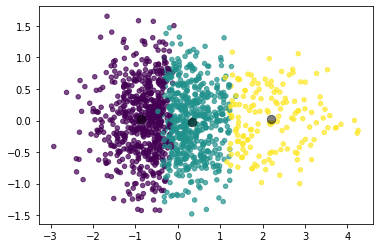

In [1175]:
# create a scatter plot
plt.scatter(pca_sims[:, 0], pca_sims[:, 1], c=cluster_words, s=20, alpha=0.7)
# select cluster centers
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [1176]:
pd.DataFrame(pd.Series(cluster_words).value_counts(), columns=['WordsNb']).T

,0,1,2
WordsNb,599,537,154


In [1177]:
keywords_clusters = {keyword: cluster for keyword, cluster in zip(keywords_counter.keys(), cluster_words)}
# sorted(keywords_clusters.items(), key=lambda kv: kv[1])

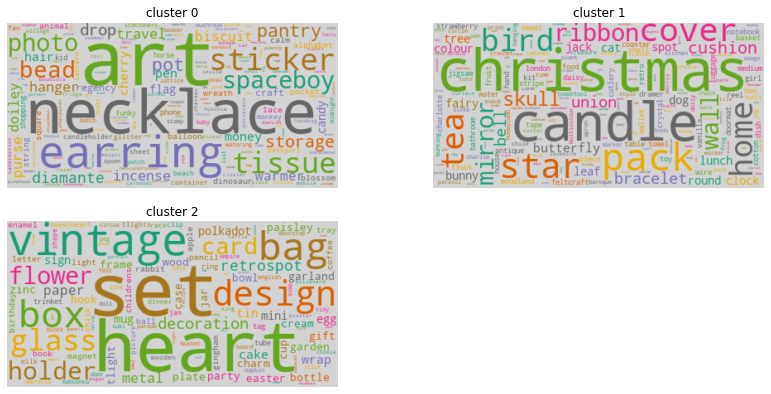

In [1178]:
def make_word_cloud(words, cluster):
    ax = fig.add_subplot(4,2,cluster)
    word_cloud = WordCloud(background_color='lightgrey', colormap='Dark2')
    word_cloud.generate_from_frequencies({w: f for w, f in keywords_counter.items() if w in words})
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis('off')
    # word_cloud.to_file('path')
    plt.title('cluster {}'.format(cluster - 1))

fig = plt.figure(1, figsize=(14,14))
for i in range(3):
    make_word_cloud([w for w, c in keywords_clusters.items() if c == i], i + 1) 